In [19]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from numpy.random import choice
import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
seq_df = pd.read_table('05/data/family_classification_sequences.tab')
seq_df.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Sequences</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...</td>
    </tr>
  </tbody>
</table>
</div>

In [3]:
seq2num = {}
num2seq = {}

def build_mapping(pos, seq, num):
    if pos == 3:
        seq2num[seq] = num
        num2seq[num] = seq
        return num + 1
    for letter in range(ord('A'), ord('Z') + 1):
        num = build_mapping(pos + 1, seq + chr(letter), num)
    return num

cnt = build_mapping(0, '', 0)
assert(len(num2seq) == cnt)

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [seq2num[cropped_seq[i:i+3]] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []
    for i in range(min(df.shape[0], 1000)):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='05/data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving 05/data/all_codones.pickle


In [7]:
presented_codones = set([item for sublist in all_codones for item in sublist])
num2cod = {}
cod2num = {}
new_index = {}
for index, cod in enumerate(presented_codones):
    num2cod[index] = num2seq[cod]
    cod2num[num2seq[cod]] = index
    new_index[cod] = index

all_codones = [[new_index[item] for item in sublist] for sublist in all_codones]
counts = [0] * len(presented_codones)

for sublist in all_codones:
    for item in sublist:
        counts[item] += 1

In [48]:
class DataProducer:
    def __init__(self, data, vocab_size, word_counts, batch_size, skip_window, num_neg_samples):
        self.data = data
        self.vocab_size = vocab_size
        self.num_neg_samples = num_neg_samples
        self.batch_size = batch_size
        self.skip_window = skip_window
        self.p_distr = self.get_distribution(word_counts)

    @staticmethod
    def get_distribution(word_counts):
        word_counts = torch.FloatTensor(word_counts)
        distr = word_counts / word_counts.sum()
        distr = distr.pow(3 / 4)
        distr = distr / distr.sum()
        return distr.numpy()

    def neg_sample(self, batch_size):
        return torch.LongTensor(
            choice(self.vocab_size, size=(batch_size, self.num_neg_samples), p=self.p_distr)
        )

    def generate_sample(self, index_words_list, context_window_size):
        """ Form training pairs according to the skip-gram model. """
        for index_words in index_words_list:
            for index, center in enumerate(index_words):
                context = random.randint(1, context_window_size)
                # get a random target before the center word
                for target in index_words[max(0, index - context): index]:
                    yield center, target
                # get a random target after the center word
                for target in index_words[index + 1: index + context + 1]:
                    yield center, target

    def get_batch(self, iterator, batch_size):
        """ Group a numerical stream into batches and yield them as Numpy arrays. """
        while True:
            center_batch = np.zeros(batch_size, dtype=np.int32)
            target_batch = np.zeros(batch_size, dtype=np.int32)
            for index in range(batch_size):
                center_batch[index], target_batch[index] = next(iterator)
            yield torch.LongTensor(center_batch), torch.LongTensor(target_batch)

    def batch_iterator(self):
        single_gen = self.generate_sample(self.data, context_window_size=self.skip_window)
        batch_gen = self.get_batch(single_gen, batch_size=self.batch_size)
        return batch_gen

In [72]:
class SkipGramModel(nn.Module):
    """ word2vec model """

    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embed_centers = nn.Embedding(vocab_size, embed_size)
        self.embed_contexts = nn.Embedding(vocab_size, embed_size)

    def forward(self, centers, pos_contexts, neg_contexts):
        batch_size = centers.size()[0]

        centers = self.embed_centers(centers)
        pos_contexts = self.embed_contexts(pos_contexts)
        neg_contexts = self.embed_contexts(neg_contexts)

        pos_mm = torch.bmm(centers.unsqueeze(1), pos_contexts.unsqueeze(2)).squeeze()
        pos_loss = F.logsigmoid(pos_mm).sum()

        neg_mm = torch.bmm(neg_contexts, centers.unsqueeze(2)).squeeze().sum(dim=1)
        neg_loss = F.logsigmoid(-neg_mm).sum()

        return -(pos_loss + neg_loss) / batch_size
    
    def get_embeddings(self):
        return self.embed_centers.weight

In [81]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window
VOCAB_SIZE = len(presented_codones)
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .05
EPOCHS = 1
SKIP_STEP = 200

In [82]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [83]:
def train_model(net, data_producer, optimizer, logger, epochs):
    for epoch in range(epochs):
        for i, (centers, pos_contexts) in enumerate(data_producer.batch_iterator()):
            batch_size = centers.size()[0]

            optimizer.zero_grad()
            
            loss = net(centers, pos_contexts, data_producer.neg_sample(batch_size))
            loss.backward()
            
            optimizer.step()
            
            logger.add_scalar('Loss', loss, i + 1)
            if (i + 1) % SKIP_STEP == 0:
                print("loss = {} at step {}".format(loss, i + 1))
    
    embeddings = net.get_embeddings()
    logger.add_embedding(embeddings)
    return embeddings

In [84]:
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
dp = DataProducer(all_codones, VOCAB_SIZE, counts, BATCH_SIZE, SKIP_WINDOW, NUM_SAMPLED)
logger = SummaryWriter()
final_embed_matrix = train_model(model, dp, optimizer, logger, EPOCHS)

loss = 12.960344314575195 at step 200


loss = 11.518355369567871 at step 400


loss = 11.281578063964844 at step 600


loss = 12.703131675720215 at step 800


loss = 11.67991828918457 at step 1000


loss = 12.627548217773438 at step 1200


loss = 13.065961837768555 at step 1400


loss = 10.354677200317383 at step 1600


loss = 11.803271293640137 at step 1800


loss = 13.717572212219238 at step 2000


loss = 13.512469291687012 at step 2200


loss = 12.251338958740234 at step 2400


loss = 10.059890747070312 at step 2600


loss = 15.665830612182617 at step 2800


loss = 14.178812026977539 at step 3000


loss = 12.917523384094238 at step 3200


loss = 12.442159652709961 at step 3400


loss = 13.871596336364746 at step 3600


loss = 12.410636901855469 at step 3800


loss = 12.444903373718262 at step 4000


loss = 12.758052825927734 at step 4200


loss = 10.035419464111328 at step 4400


loss = 13.692251205444336 at step 4600


loss = 11.122299194335938 at step 4800


loss = 13.747457504272461 at step 5000


loss = 12.742071151733398 at step 5200


loss = 12.460633277893066 at step 5400


loss = 11.53911018371582 at step 5600


loss = 10.732162475585938 at step 5800


loss = 13.458284378051758 at step 6000


loss = 13.463061332702637 at step 6200


loss = 14.032411575317383 at step 6400


loss = 11.867841720581055 at step 6600


loss = 12.48335075378418 at step 6800


loss = 12.495243072509766 at step 7000


loss = 15.171258926391602 at step 7200


loss = 12.827394485473633 at step 7400


loss = 13.343914985656738 at step 7600


loss = 13.692586898803711 at step 7800


loss = 12.58045768737793 at step 8000


loss = 14.086750030517578 at step 8200


loss = 9.960354804992676 at step 8400


loss = 12.905580520629883 at step 8600


loss = 13.78575611114502 at step 8800


loss = 12.645576477050781 at step 9000


loss = 12.96993637084961 at step 9200


loss = 11.69523811340332 at step 9400


loss = 11.66325855255127 at step 9600


loss = 10.105754852294922 at step 9800


loss = 12.152010917663574 at step 10000


loss = 12.96872329711914 at step 10200


loss = 9.40080451965332 at step 10400


loss = 13.709067344665527 at step 10600


loss = 12.578385353088379 at step 10800


loss = 11.573492050170898 at step 11000


loss = 10.234983444213867 at step 11200


loss = 11.204206466674805 at step 11400


loss = 10.200357437133789 at step 11600


loss = 12.441656112670898 at step 11800


loss = 10.350711822509766 at step 12000


loss = 15.570549011230469 at step 12200


loss = 9.875638961791992 at step 12400


loss = 11.855798721313477 at step 12600


loss = 12.225217819213867 at step 12800


loss = 11.438953399658203 at step 13000


loss = 11.473936080932617 at step 13200


loss = 11.730367660522461 at step 13400


loss = 11.41936206817627 at step 13600


loss = 12.147037506103516 at step 13800


loss = 13.840476989746094 at step 14000


loss = 11.984540939331055 at step 14200


loss = 12.745316505432129 at step 14400


loss = 13.61793327331543 at step 14600


loss = 13.354251861572266 at step 14800


loss = 11.18799877166748 at step 15000


loss = 10.964580535888672 at step 15200


loss = 11.735261917114258 at step 15400


In [86]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [87]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(cod2num, key=cod2num.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0        x1 codone
0 -0.078418  0.289227    AAA
1 -1.268504 -3.245250    AAC
2  0.996009 -1.656350    AAD
3  1.954191  1.460420    AAE
4 -1.009279  2.077147    AAF

In [88]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

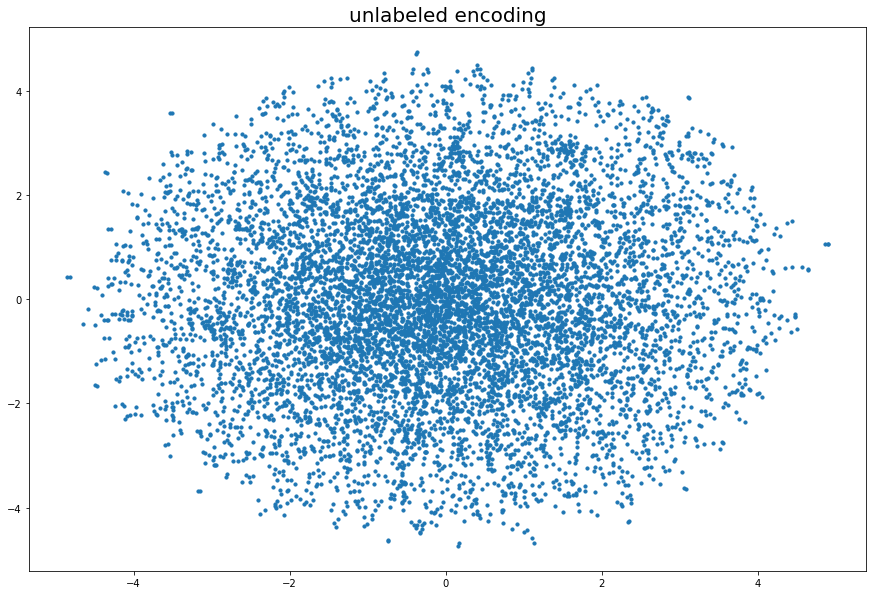

In [89]:
plot_tsne_df(tsne_df)

In [90]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [91]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [92]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [93]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity       mass  number_of_atoms      volume
0  AAA        1.800000  71.077900        13.000000   88.600000
1  AAC        2.033333  81.766233        13.333333   95.233333
2  AAD        0.033333  85.747733        14.000000   96.100000
3  AAE        0.033333  90.423267        15.000000  105.200000
4  AAF        2.133333  96.443233        16.333333  122.366667

In [94]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity       mass  number_of_atoms      volume        x0  \
0  AAA        1.800000  71.077900        13.000000   88.600000 -0.078418   
1  AAC        2.033333  81.766233        13.333333   95.233333 -1.268504   
2  AAD        0.033333  85.747733        14.000000   96.100000  0.996009   
3  AAE        0.033333  90.423267        15.000000  105.200000  1.954191   
4  AAF        2.133333  96.443233        16.333333  122.366667 -1.009279   

         x1  
0  0.289227  
1 -3.245250  
2 -1.656350  
3  1.460420  
4  2.077147

In [95]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

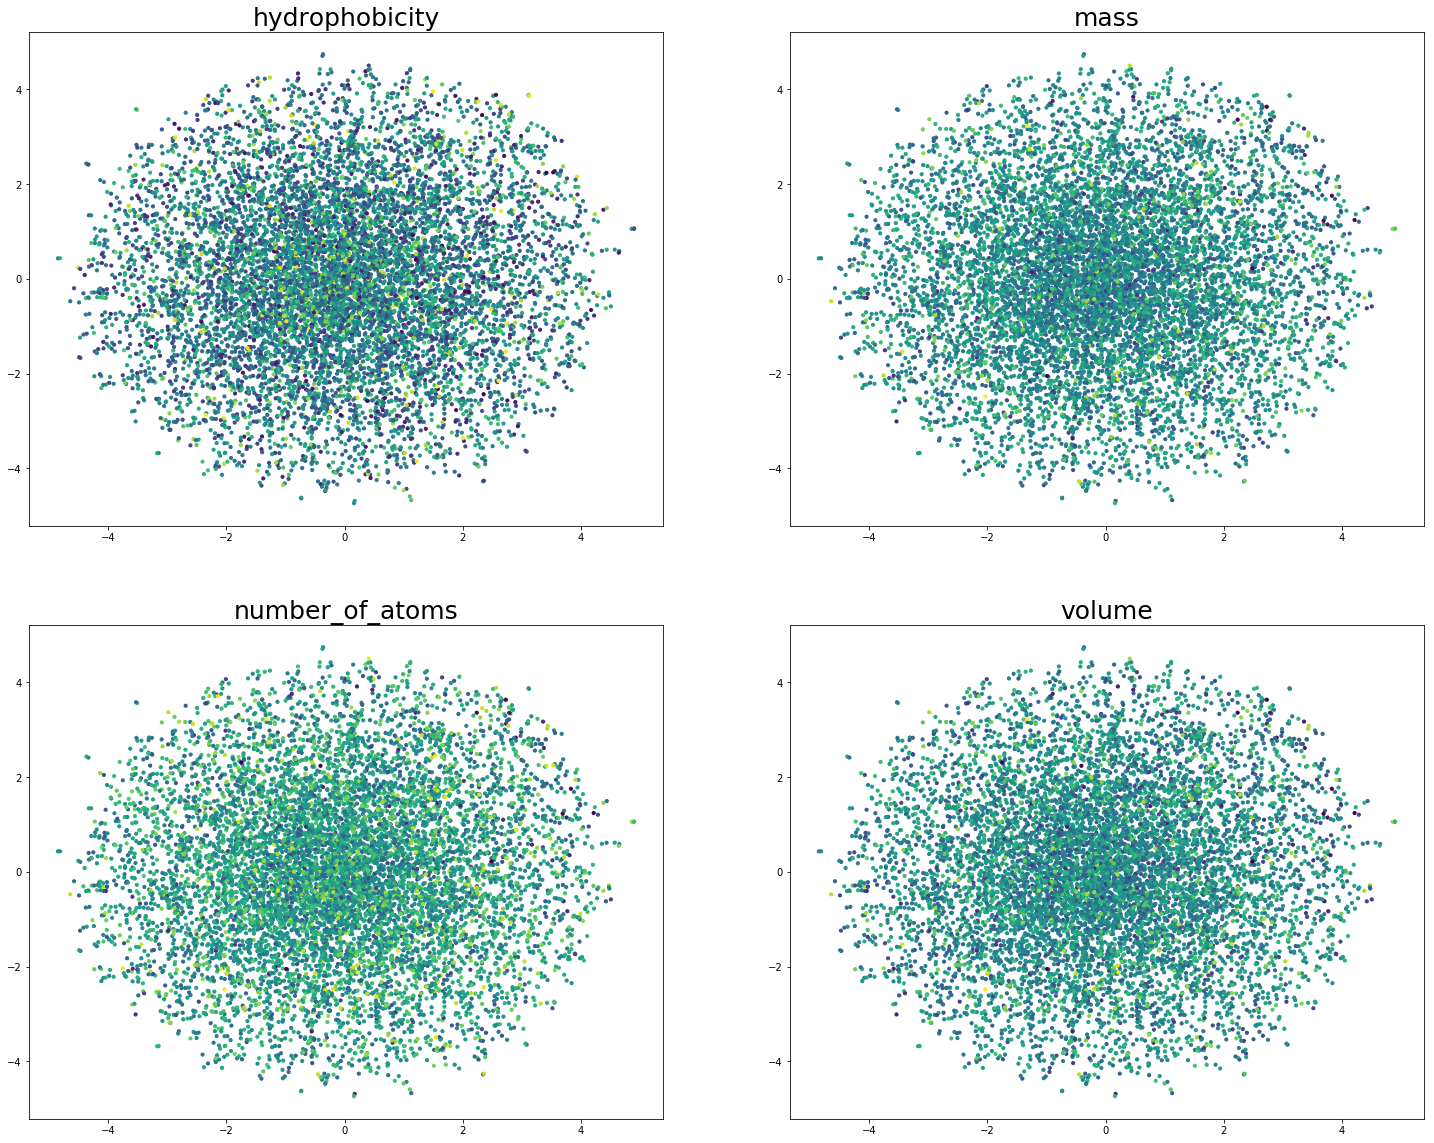

In [96]:
plot_embedding_properties(final_df)

In [97]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

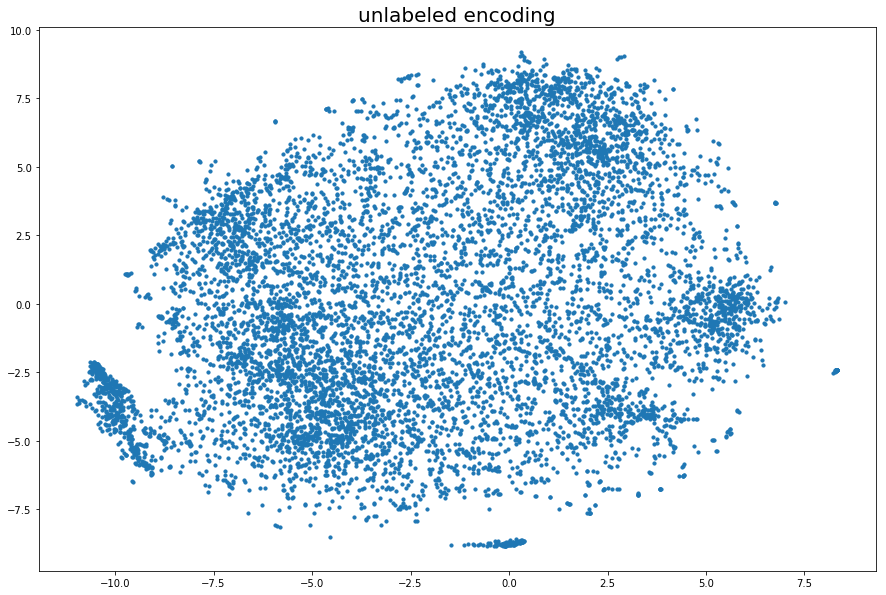

In [98]:
plot_tsne_df(gensim_tsne_df)

In [99]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

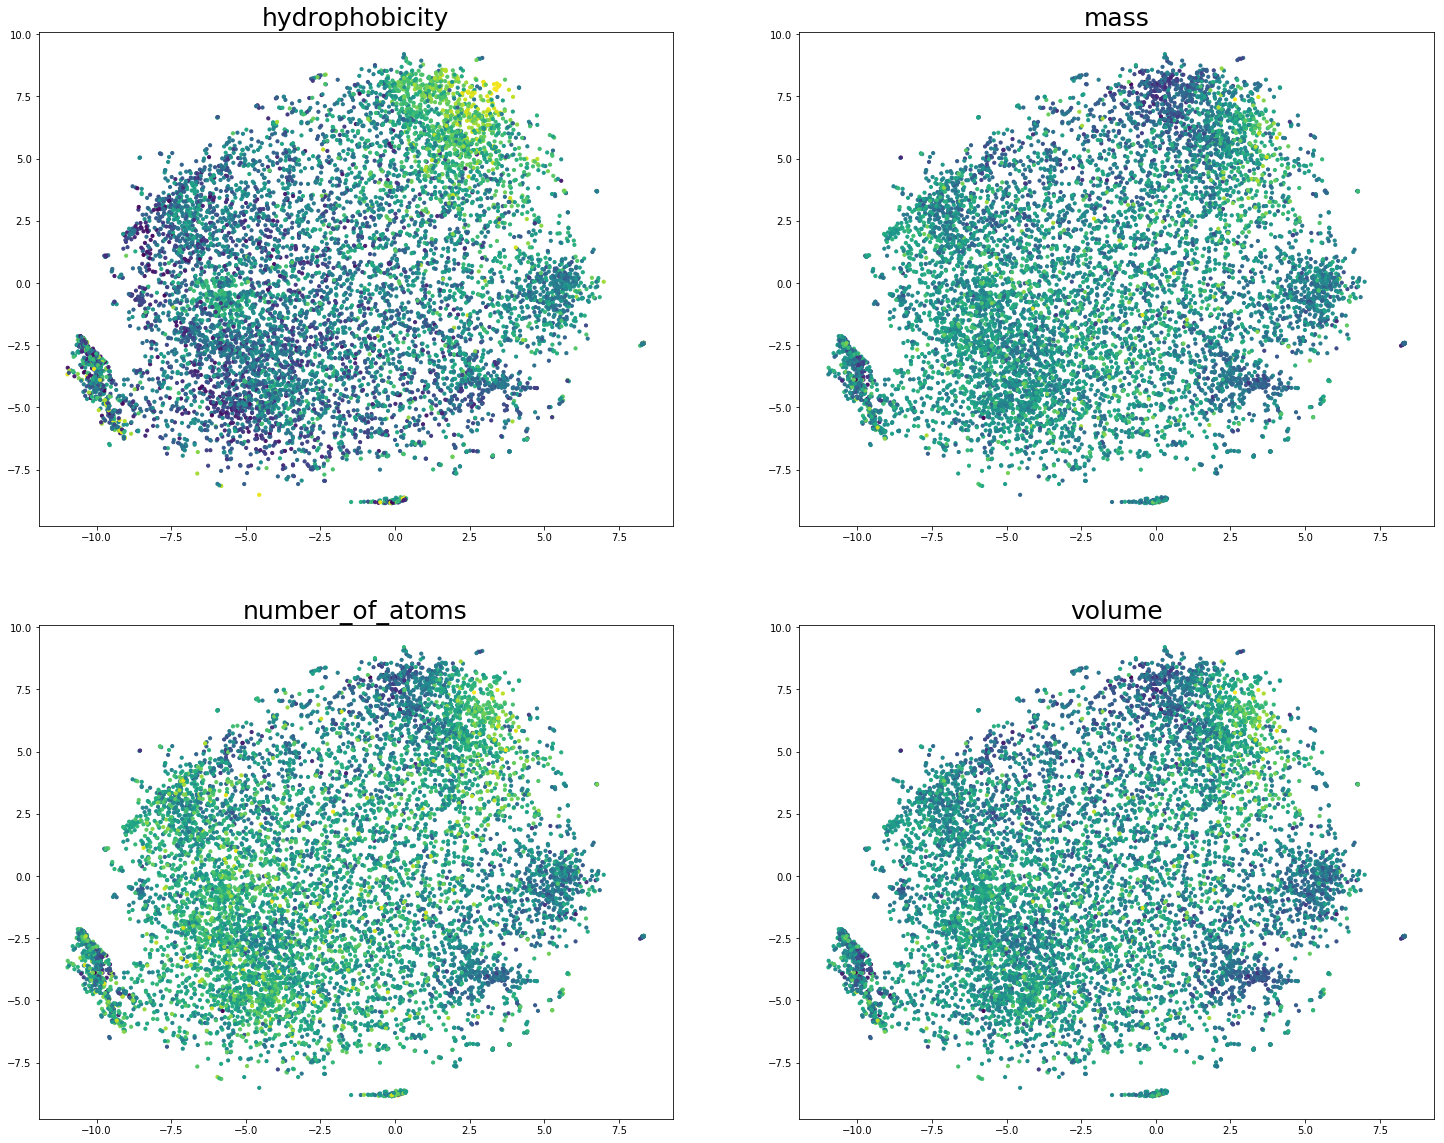

In [100]:
plot_embedding_properties(final_df_nice)

In [12]:
cnt_batches = 0
cnt_examples = 0
for batch in data_producer.batch_iterator():
    cnt_batches += 1
    cnt_examples += len(batch[0])
print(cnt_batches)
print(cnt_examples)

38706
4954368


/home/egor/anaconda3/envs/07-dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'DataProducer.get_batch' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until
